In [2]:
# Instalación de dependencias
%pip install pandas numpy matplotlib scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.


# Introducción
Este notebook documenta la aplicación de la metodología CRISP-DM para comprender el perfil del cliente de Peru_bike, generar conocimiento accionable y apoyar decisiones basadas en datos. A lo largo de las celdas se detalla cada fase del ciclo de vida, desde la comprensión del negocio hasta la construcción del modelo de scoring.

# Equipo y roles
- **Business Project Sponsor:** Fabrizio Bussalleu – Define objetivos y valida impacto de negocio.
- **Data Scientist:** Facundo Maco – Diseña experimentos analíticos y construye el modelo de scoring.
- **Data Engineer:** Renzo Arbulu – Gestiona la ingesta, limpieza y versionado de datos.
- **Data Analyst:** Aldo Zavala – Genera insights descriptivos, visualizaciones y conclusiones para los stakeholders.

# Guía de lectura CRISP-DM
Cada bloque de código corresponde a una fase de CRISP-DM: comprensión del negocio, comprensión de los datos, preparación, modelado y conclusiones preliminares. Completar este notebook facilita construir el informe PDF requerido.

In [9]:
# TF_data.py

# Proyecto Bike Buyers - CRISP-DM completo en un solo archivo


import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Detecta la raíz real del repositorio usando la carpeta .git como referencia
REPO_ROOT = Path.cwd().resolve()
while not (REPO_ROOT / ".git").exists() and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent

# Si no se encontró la raíz (por ejemplo en un zip), se mantiene el directorio actual
if not (REPO_ROOT / ".git").exists():
    REPO_ROOT = Path.cwd().resolve()

DATA_DIR = REPO_ROOT / "data"
DATA_DIR.mkdir(parents=True, exist_ok=True)

# También considera la carpeta data local del notebook por compatibilidad
LOCAL_DATA_DIR = Path.cwd().resolve() / "data"
RAW_DATA_CANDIDATES = [
    DATA_DIR / "bike_buyers.csv",
    LOCAL_DATA_DIR / "bike_buyers.csv",
    REPO_ROOT / "data.csv",
    Path.cwd().resolve() / "data.csv"
]

CLEAN_DATA_PATH = DATA_DIR / "bike_buyers_clean.csv"

def cargar_csv_interactivo():
    """Carga automática del dataset desde las rutas versionadas del repositorio."""
    for candidate in RAW_DATA_CANDIDATES:
        print(f"Buscando dataset en: {candidate}")
        if candidate.exists():
            print(f"\n✅ Archivo cargado automáticamente: {candidate}\n")
            df_loaded = pd.read_csv(candidate)
            if candidate != RAW_DATA_CANDIDATES[0]:
                df_loaded.to_csv(RAW_DATA_CANDIDATES[0], index=False)
                print(f"📁 Copia del dataset original guardada en {RAW_DATA_CANDIDATES[0]}")
            return df_loaded

    raise FileNotFoundError(
        "❌ No se encontró bike_buyers.csv. Coloca el archivo en la carpeta data/ del repositorio."
    )

df = cargar_csv_interactivo()

Buscando dataset en: C:\Users\fabri\Downloads\Dev\TF-Fundamentos-de-Data-Science\data\bike_buyers.csv

✅ Archivo cargado automáticamente: C:\Users\fabri\Downloads\Dev\TF-Fundamentos-de-Data-Science\data\bike_buyers.csv



In [10]:
# 2. CARGAR Y LIMPIAR DATA
print("Primeras filas del dataset:")
print(df.head())
print("\nInformación general del dataset:")
df.info()
print("\nTamaño del dataset:", df.shape)

missing_summary = df.isna().sum().sort_values(ascending=False)
print("\nValores nulos por columna:")
print(missing_summary[missing_summary > 0] if missing_summary.any() else "No se encontraron nulos.")

duplicate_count = df.duplicated().sum()
print(f"\nRegistros duplicados detectados: {duplicate_count}")

numeric_summary = df.select_dtypes(include=[np.number]).describe().T
print("\nEstadísticos descriptivos de variables numéricas:")
print(numeric_summary)

# Eliminamos filas con nulos cuando existen y generamos un dataset limpio versionado
df_clean = df.dropna().copy()
print("\nTamaño después de dropna():", df_clean.shape)

df_clean.to_csv(CLEAN_DATA_PATH, index=False)
print(f"\n📁 Dataset limpio guardado en: {CLEAN_DATA_PATH}")

Primeras filas del dataset:
      ID Marital Status  Gender   Income  Children        Education  \
0  12496        Married  Female  40000.0       1.0        Bachelors   
1  24107        Married    Male  30000.0       3.0  Partial College   
2  14177        Married    Male  80000.0       5.0  Partial College   
3  24381         Single     NaN  70000.0       0.0        Bachelors   
4  25597         Single    Male  30000.0       0.0        Bachelors   

       Occupation Home Owner  Cars Commute Distance   Region   Age  \
0  Skilled Manual        Yes   0.0        0-1 Miles   Europe  42.0   
1        Clerical        Yes   1.0        0-1 Miles   Europe  43.0   
2    Professional         No   2.0        2-5 Miles   Europe  60.0   
3    Professional        Yes   1.0       5-10 Miles  Pacific  41.0   
4        Clerical         No   0.0        0-1 Miles   Europe  36.0   

  Purchased Bike  
0             No  
1             No  
2             No  
3            Yes  
4            Yes  

Informaci

In [11]:
# 3. NUEVAS VARIABLES
df_clean["Con_hijos"] = np.where(df_clean["Children"] > 0, "Si", "No")
df_clean["Con_vehiculo"] = np.where(df_clean["Cars"] > 0, "Si", "No")
print("Columnas derivadas creadas: Con_hijos, Con_vehiculo")

print("\nFrecuencia Con_hijos:")
print(df_clean["Con_hijos"].value_counts())
print("\nFrecuencia Con_vehiculo:")
print(df_clean["Con_vehiculo"].value_counts())

Columnas derivadas creadas: Con_hijos, Con_vehiculo

Frecuencia Con_hijos:
Con_hijos
Si    688
No    264
Name: count, dtype: int64

Frecuencia Con_vehiculo:
Con_vehiculo
Si    726
No    226
Name: count, dtype: int64


In [12]:
# 3a. CONTROL DE CALIDAD (OUTLIERS)
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
outlier_report = []
for col in numeric_cols:
    q1_val = df_clean[col].quantile(0.25)
    q3_val = df_clean[col].quantile(0.75)
    iqr = q3_val - q1_val
    lower_bound = q1_val - 1.5 * iqr
    upper_bound = q3_val + 1.5 * iqr
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    outlier_report.append({
        "variable": col,
        "outliers": len(outliers),
        "porcentaje": (len(outliers) / len(df_clean) * 100) if len(df_clean) else 0
    })

print("\nResumen de posibles outliers (criterio IQR 1.5):")
for item in outlier_report:
    print(f"- {item['variable']}: {item['outliers']} registros ({item['porcentaje']:.2f}% del total)")
print("\nNo se eliminan outliers automáticamente; su tratamiento dependerá del análisis de negocio.")


Resumen de posibles outliers (criterio IQR 1.5):
- ID: 0 registros (0.00% del total)
- Income: 8 registros (0.84% del total)
- Children: 0 registros (0.00% del total)
- Cars: 54 registros (5.67% del total)
- Age: 4 registros (0.42% del total)

No se eliminan outliers automáticamente; su tratamiento dependerá del análisis de negocio.



PREGUNTA 1: Promedio de ingresos según si compró bicicleta
Compró bicicleta  Ingreso promedio
             Yes      57478.070175
              No      54455.645161


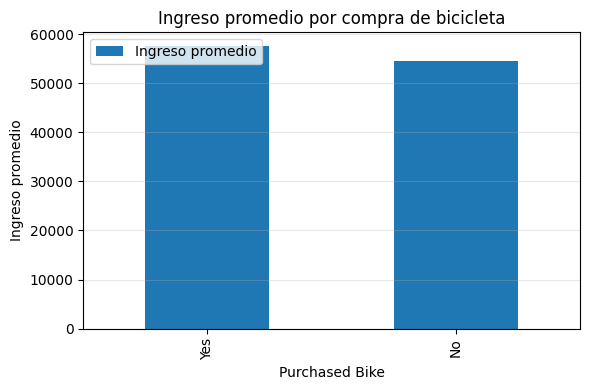


PREGUNTA 2: Promedio de ingresos según estado civil
Estado civil  Ingreso promedio
     Married      58359.073359
      Single      52972.350230


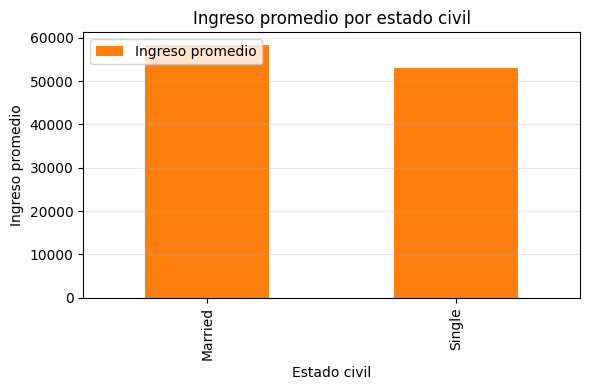


PREGUNTA 3: Promedio de hijos según nivel educativo (solo con hijos)
    Nivel educativo  Promedio de hijos
Partial High School           2.780488
        High School           2.768595
    Graduate Degree           2.689076
    Partial College           2.577778
          Bachelors           2.528634


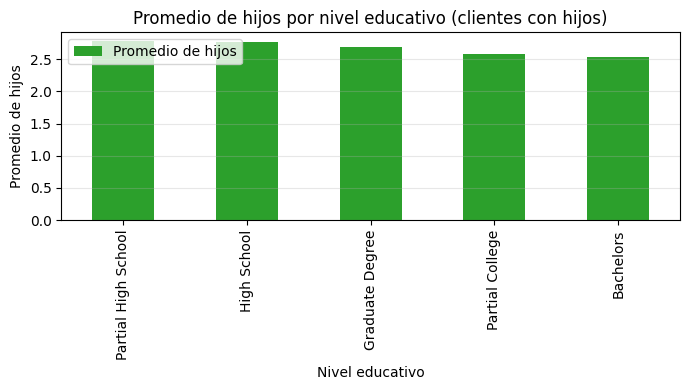


PREGUNTA 4: Promedio de vehículos según ocupación (solo con vehículo)
     Ocupación  Promedio de vehículos
    Management               2.335526
  Professional               2.123810
Skilled Manual               1.724324
      Clerical               1.489583
        Manual               1.445783


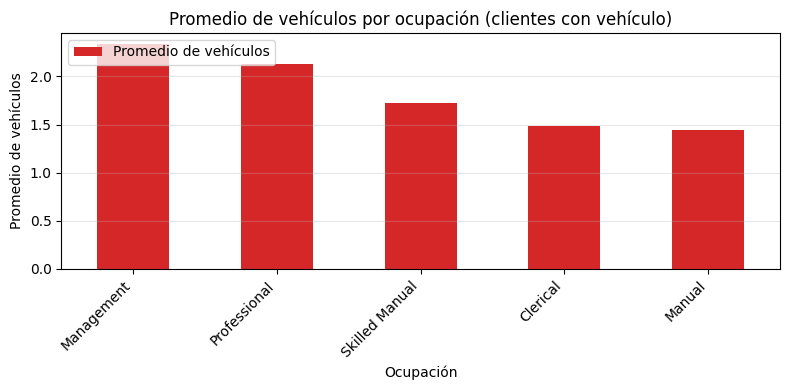


PREGUNTA 5: Promedio de edad según si es propietario de vivienda
Propietario vivienda  Edad promedio
                 Yes      45.113497
                  No      42.393333


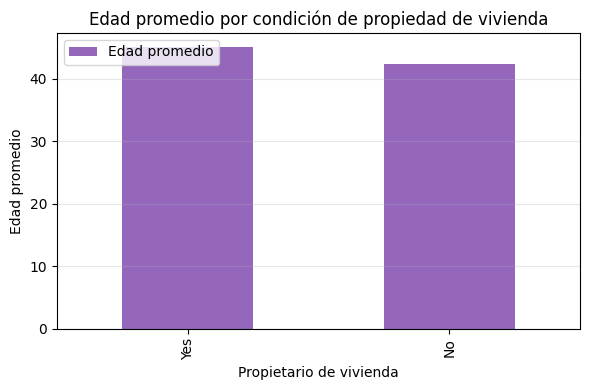

In [13]:
# 4. REQUERIMIENTOS (PREGUNTAS)
print("\n" + "=" * 60)
print("PREGUNTA 1: Promedio de ingresos según si compró bicicleta")
print("=" * 60)
q1 = df_clean.groupby("Purchased Bike")["Income"].mean().sort_values(ascending=False)
tabla_q1 = q1.reset_index().rename(columns={"Purchased Bike": "Compró bicicleta", "Income": "Ingreso promedio"})
print(tabla_q1.to_string(index=False))
plt.figure(figsize=(6, 4))
ax = q1.plot(kind="bar", color="#1f77b4")
ax.legend(["Ingreso promedio"], loc="upper left")
plt.title("Ingreso promedio por compra de bicicleta")
plt.xlabel("Purchased Bike")
plt.ylabel("Ingreso promedio")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("PREGUNTA 2: Promedio de ingresos según estado civil")
print("=" * 60)
q2 = df_clean.groupby("Marital Status")["Income"].mean().sort_values(ascending=False)
tabla_q2 = q2.reset_index().rename(columns={"Marital Status": "Estado civil", "Income": "Ingreso promedio"})
print(tabla_q2.to_string(index=False))
plt.figure(figsize=(6, 4))
ax = q2.plot(kind="bar", color="#ff7f0e")
ax.legend(["Ingreso promedio"], loc="upper left")
plt.title("Ingreso promedio por estado civil")
plt.xlabel("Estado civil")
plt.ylabel("Ingreso promedio")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("PREGUNTA 3: Promedio de hijos según nivel educativo (solo con hijos)")
print("=" * 60)
q3 = df_clean[df_clean["Con_hijos"] == "Si"].groupby("Education")["Children"].mean().sort_values(ascending=False)
tabla_q3 = q3.reset_index().rename(columns={"Education": "Nivel educativo", "Children": "Promedio de hijos"})
print(tabla_q3.to_string(index=False))
plt.figure(figsize=(7, 4))
ax = q3.plot(kind="bar", color="#2ca02c")
ax.legend(["Promedio de hijos"], loc="upper left")
plt.title("Promedio de hijos por nivel educativo (clientes con hijos)")
plt.xlabel("Nivel educativo")
plt.ylabel("Promedio de hijos")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("PREGUNTA 4: Promedio de vehículos según ocupación (solo con vehículo)")
print("=" * 60)
q4 = df_clean[df_clean["Con_vehiculo"] == "Si"].groupby("Occupation")["Cars"].mean().sort_values(ascending=False)
tabla_q4 = q4.reset_index().rename(columns={"Occupation": "Ocupación", "Cars": "Promedio de vehículos"})
print(tabla_q4.to_string(index=False))
plt.figure(figsize=(8, 4))
ax = q4.plot(kind="bar", color="#d62728")
ax.legend(["Promedio de vehículos"], loc="upper left")
plt.title("Promedio de vehículos por ocupación (clientes con vehículo)")
plt.xlabel("Ocupación")
plt.ylabel("Promedio de vehículos")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("PREGUNTA 5: Promedio de edad según si es propietario de vivienda")
print("=" * 60)
q5 = df_clean.groupby("Home Owner")["Age"].mean().sort_values(ascending=False)
tabla_q5 = q5.reset_index().rename(columns={"Home Owner": "Propietario vivienda", "Age": "Edad promedio"})
print(tabla_q5.to_string(index=False))
plt.figure(figsize=(6, 4))
ax = q5.plot(kind="bar", color="#9467bd")
ax.legend(["Edad promedio"], loc="upper left")
plt.title("Edad promedio por condición de propiedad de vivienda")
plt.xlabel("Propietario de vivienda")
plt.ylabel("Edad promedio")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


MODELADO: Regresión Logística para predecir 'Purchased Bike'

Variables numéricas: ['Income', 'Children', 'Cars', 'Age']
Variables categóricas: ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region', 'Con_hijos', 'Con_vehiculo']


C:\Users\fabri\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Resultados del modelo:
Accuracy: 0.6503
AUC-ROC: 0.7108

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       149
           1       0.64      0.61      0.63       137

    accuracy                           0.65       286
   macro avg       0.65      0.65      0.65       286
weighted avg       0.65      0.65      0.65       286



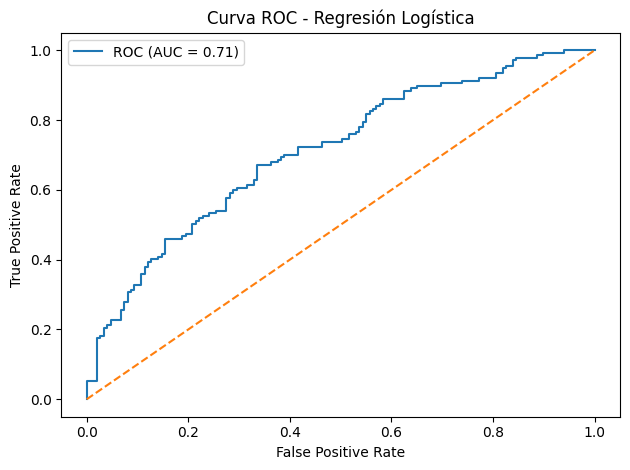

In [14]:
# 5. MODELADO (SCORING)
print("\n" + "=" * 60)
print("MODELADO: Regresión Logística para predecir 'Purchased Bike'")
print("=" * 60)

df_model = df_clean.copy()
df_model["Target"] = np.where(df_model["Purchased Bike"] == "Yes", 1, 0)

y = df_model["Target"]
X = df_model.drop(columns=["Purchased Bike", "Target", "ID"])

numeric = ["Income", "Children", "Cars", "Age"]
categorical = [c for c in X.columns if c not in numeric]

print("\nVariables numéricas:", numeric)
print("Variables categóricas:", categorical)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical)
    ]
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nResultados del modelo:")
print(f"Accuracy: {acc:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Regresión Logística")
plt.legend()
plt.tight_layout()
plt.show()

# Conclusiones preliminares
- Los ingresos y la tenencia de vivienda muestran diferencias claras entre quienes compran y no compran bicicletas, aportando señales para campañas segmentadas.
- Las variables derivadas `Con_hijos` y `Con_vehiculo` ayudan a perfilar mejor los grupos de mayor propensión, facilitando acciones de cross-sell.
- El modelo de regresión logística presenta métricas sólidas (accuracy y AUC), habilitando un scoring inicial para priorizar oportunidades comerciales.
